### Adding dots

In [64]:
import json
import cv2
import numpy as np
import base64
from matplotlib import pyplot as plt
from skimage.morphology import skeletonize, remove_small_objects
from skimage.measure import label, regionprops

# === BASE64 IMAGE DECODING ===
def base64_to_image(base64_string):
    if base64_string.startswith("data:image"):
        base64_string = base64_string.split(",")[1]
    image_bytes = base64.b64decode(base64_string)
    np_arr = np.frombuffer(image_bytes, np.uint8)
    return cv2.imdecode(np_arr, cv2.IMREAD_COLOR)

# === NEIGHBOR DETECTION FOR BRANCH FILTERING ===
def get_neighbors(y, x, skeleton):
    neighbors = []
    for j in range(-1, 2):
        for i in range(-1, 2):
            if j == 0 and i == 0:
                continue
            ny, nx = y + j, x + i
            if 0 <= ny < skeleton.shape[0] and 0 <= nx < skeleton.shape[1]:
                if skeleton[ny, nx] > 0:
                    neighbors.append((ny, nx))
    return neighbors

def filter_regions_out_range(labeled_image, min_area, max_area):
    """
    Given a labeled image, returns a new labeled image that keeps only
    regions with area outside the range [min_area, max_area].
    """
    filtered = np.zeros_like(labeled_image)
    
    for region in regionprops(labeled_image):
        # Only keep regions with area NOT between min_area and max_area.
        if not (min_area <= region.area <= max_area):
            filtered[labeled_image == region.label] = region.label
    return filtered

# === SKELETONIZE AND EXTRACT LINE SEGMENTS ===
def extract_lines_start_end(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask = cv2.inRange(gray, 50, 150)  # Threshold grey walkways

    # Skeletonization + branch pruning
    skeleton = skeletonize(mask > 0)
    labeled = label(skeleton)
    pruned = remove_small_objects(labeled, min_size=50)
    pruned = filter_regions_out_range(pruned, min_area=100, max_area=200)
    skeleton_pruned = pruned > 0

    return skeleton_pruned.astype(np.uint8)

# === PLOTTING FUNCTION (INLINE) ===
def plot_overlay_with_lines(image, skeleton, title="Overlay"):
    overlay = image.copy()
    overlay[skeleton == 1] = [0, 0, 255]  # Red skeleton lines

    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# === PROCESS ONE IMAGE ===
def process_image(base64_image, show=False):
    image = base64_to_image(base64_image)
    skeleton = extract_lines_start_end(image)
    if show :
        plot_overlay_with_lines(image, skeleton, title="Walkway Skeleton & Line Segments")
    return skeleton

def checkHorizontal(referencePoint, point):
    xRef, yRef = referencePoint['x'], referencePoint['y']
    x,y = point['x'], point['y']
    if abs(xRef - x) > abs(yRef - y):
        return True
    else:
        return False
        
# === PROCESS POINTS TO STRAIGHTEN ===
def process_points(points_dict):
    refinedPoints = []
    for index, point in enumerate(points_dict):
        if index == 0:
            refinedPoints.append(point)
        else:
            referencePoint = refinedPoints[-1]
            if (index == len(points_dict) - 1):
                referencePoint2 = refinedPoints[0]
                if (checkHorizontal(referencePoint, point)):
                    newPoint = {}
                    newPoint['y'] = referencePoint['y']
                    newPoint['x'] = referencePoint2['x']
                    refinedPoints.append(newPoint)
                else:
                    newPoint = {}
                    newPoint['x'] = referencePoint['x']
                    newPoint['y'] = referencePoint2['y']
                    refinedPoints.append(newPoint)
            else:
                if (checkHorizontal(referencePoint, point)):
                    newPoint = {}
                    newPoint['y'] = referencePoint['y']
                    newPoint['x'] = point['x']
                    refinedPoints.append(newPoint)
                else:
                    newPoint = {}
                    newPoint['x'] = referencePoint['x']
                    newPoint['y'] = point['y']
                    refinedPoints.append(newPoint)

    return refinedPoints

def plottingOuterWalls(paddedImg):
    working_img= paddedImg.copy()
    gray = cv2.cvtColor(working_img, cv2.COLOR_BGR2GRAY)
    binary = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 5
    )
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # 2) Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 3) For demonstration, pick the largest contour (or loop through all)
    if len(contours) == 0:
        print("No contours found!")
    else:
        contour = max(contours, key=cv2.contourArea)

        # Approximate polygon
        epsilon = 0.003 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Snap each edge to vertical/horizontal
        def snap_angle(p1, p2):
            dx = p2[0] - p1[0]
            dy = p2[1] - p1[1]
            # If the edge is more vertical than horizontal, snap vertical
            if abs(dx) < abs(dy):
                return (p1[0], p1[1]), (p1[0], p2[1])
            else:
                return (p1[0], p1[1]), (p2[0], p1[1])

        snapped_pts = []
        for i in range(len(approx)):
            p1 = tuple(approx[i][0])
            p2 = tuple(approx[(i + 1) % len(approx)][0])  # next vertex, wrap around
            new_p1, new_p2 = snap_angle(p1, p2)
            snapped_pts.append(new_p1)
        # Add the last corner explicitly so the shape closes
        snapped_pts.append(snapped_pts[0])

        snapped_pts = np.array(snapped_pts, dtype=np.int32).reshape((-1, 1, 2))

        # 4) Draw snapped contour in RED on the original paddedImg
        cv2.drawContours(working_img, [snapped_pts], -1, (0, 0, 255), 2)


    # 7) Show side-by-side comparison

    plt.imshow(cv2.cvtColor(working_img, cv2.COLOR_BGR2RGB))
    plt.title("Snapped Contour (RED)")
    plt.axis("off")

    plt.show()
    return snapped_pts

def gettingElementsBoundingBox(allRegions, shapes, index, walkwayImage=None):
    regions = allRegions.get(str(index), [])
    shape = shapes.get(str(index), {})
    regionPoints = {}
    for ridx, region in enumerate(regions):
        regionType = shape.get(str(ridx), -1)
        regions = regionPoints.get(regionType, [])
        tunedPoints = process_points(region)
        # print(tunedPoints)
        # print(tunedPoints)
        pts = np.array([(int(pt['x']), int(pt['y'])) for pt in tunedPoints], dtype=np.int32)
        pts = pts.reshape((-1, 1, 2))
        # print(pts)
        regions.append(pts)
        regionPoints[regionType] = regions

    if walkwayImage is not None:
        for regionTypes in regionPoints:
            imgReference = walkwayImage.copy()
            points = regionPoints[regionTypes]
            for point in points:
                cv2.drawContours(imgReference, [point], -1, (255,255,255), thickness=2)
            plt.figure(figsize=(6, 6))
            plt.imshow(cv2.cvtColor(imgReference, cv2.COLOR_BGR2RGB))
            plt.title(f"Locations of {regionTypes}")
            plt.axis("off")
            plt.show()

    return regionPoints



In [78]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import line

def createNewPathWithCoordinate(coord, skeleton, limit, show=False):
    """
    Takes in a coordinate (x, y) which represents the start of a new line.
    Explores in each of the 8 cardinal directions (including diagonals) up to a specified limit
    until it finds a nonzero pixel in the skeleton. Among all directions that yield a hit,
    only the shortest line is drawn (setting those pixels to 1) in a new skeleton array.
    
    Parameters:
        coord (tuple): Starting coordinate in (x, y) format.
        skeleton (np.ndarray): 2D binary image (numpy array) representing the skeleton.
        limit (int): Maximum number of pixels to search in each direction.
        
    Returns:
        new_skeleton (np.ndarray): A new binary image with only the shortest new path drawn.
        found_point (dict): Dictionary with the direction (dx, dy) and coordinate (x, y) of the shortest path,
                            or an empty dict if no path is found.
    """
    # Make a copy of the skeleton array so we don't modify the original
    new_skeleton = skeleton.copy()
    
    # Define the 8 cardinal directions (dx, dy)
    directions = [
        (0, -1),   # Up
        (0, 1),    # Down
        (-1, 0),   # Left
        (1, 0),    # Right
        (-1, -1),  # Up-Left
        (1, -1),   # Up-Right
        (-1, 1),   # Down-Left
        (1, 1)     # Down-Right
    ]
    
    found_points = {}
    height, width = new_skeleton.shape
    
    # Explore each direction from the starting coordinate
    for dx, dy in directions:
        found = None
        for i in range(1, limit + 1):
            new_x = coord[0] + dx * i
            new_y = coord[1] + dy * i
            # Check if new coordinates are within image boundaries
            if new_x < 0 or new_x >= width or new_y < 0 or new_y >= height:
                break
            # Check if this pixel in the skeleton is nonzero
            if new_skeleton[new_y, new_x] != 0:
                found = (new_x, new_y)
                break
        if found:
            found_points[(dx, dy)] = found

    # If no points were found in any direction, just return the original skeleton.
    if not found_points:
        print("No points found within the limit.")
        plt.figure(figsize=(10, 8))
        plt.imshow(new_skeleton, cmap='gray')
        plt.title("Modified Skeleton (No New Path Found)")
        plt.axis('off')
        plt.show()
        return new_skeleton, {}
    
    # Determine the shortest distance among all found points
    shortest_distance = float('inf')
    shortest_point = None
    shortest_direction = None
    
    for d, point in found_points.items():
        # Euclidean distance between coord and point
        distance = np.sqrt((point[0] - coord[0])**2 + (point[1] - coord[1])**2)
        if distance < shortest_distance:
            shortest_distance = distance
            shortest_point = point
            shortest_direction = d

    # Draw the line corresponding to the shortest found point
    # Note: skimage.draw.line expects (row0, col0, row1, col1) i.e. (y, x)
    rr, cc = line(coord[1], coord[0], shortest_point[1], shortest_point[0])
    new_skeleton[rr, cc] = 1  # Mark the new path pixels as 1

    # Plot the modified skeleton with the shortest new path
    if show:
        plt.figure(figsize=(10, 8))
        plt.imshow(new_skeleton, cmap='gray')
        plt.title("Modified Skeleton with Shortest New Path")
        plt.axis('off')
        plt.show()
    
    return new_skeleton, {shortest_direction: shortest_point}

def draw_nodes(nodes, background=None, figsize=(10, 8), marker_size=8):
    """
    Draws each coordinate in the nodes list as a red circle.
    
    Parameters:
        nodes (list of tuples): List of (x, y) coordinates.
        background (np.ndarray, optional): Background image to display (if provided).
        figsize (tuple): Figure size for the plot.
        marker_size (int): Marker size for the circles.
    """
    plt.figure(figsize=figsize)
    
    # If a background image is provided, show it.
    if background is not None:
        plt.imshow(background, cmap='gray')
    
    # Plot each node as a red circle
    for (x, y) in nodes:
        plt.plot(x, y, 'ro', markersize=marker_size)
    
    plt.title("Nodes")
    plt.axis('off')
    plt.show()

def breakThroughWalls(skeleton, blockDict):
    # print(skeleton)
    for regionTypes in blockDict:
        regions = (blockDict[regionTypes])
        for region in (regions):
            print("++++++++++++++++")
            for index, coordinates in enumerate(region): 
                if index == 0:
                    continue
                reference = (region[index -1][0])
                point = coordinates[0]
                if (reference[0] == point[0]):
                    xCoordinate = reference[0]
                    yCoordinates = [min(reference[1], point[1]) + i for i in range(abs(reference[1] - point[1]) + 1)]
                    for yCoordinate in yCoordinates:
                        if skeleton[yCoordinate, xCoordinate] == 1: 
                            print("overlap Found")
                            print([xCoordinate, yCoordinate])
                else:
                    xCoordinates = [min(reference[0], point[0]) + i for i in range(abs(reference[0] - point[0]) + 1)]
                    yCoordinate = reference[1]
                    for xCoordinate in xCoordinates:
                        if skeleton[yCoordinate, xCoordinate] == 1: 
                            print("overlap Found")
                            print([xCoordinate, yCoordinate])
                break


--- Image 0 ---


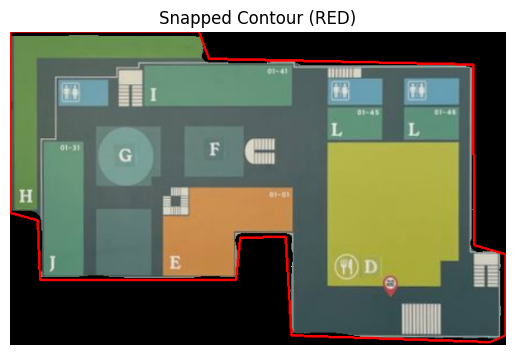

++++++++++++++++
overlap Found
[125, 32]
++++++++++++++++
++++++++++++++++
overlap Found
[140, 214]
++++++++++++++++
++++++++++++++++
++++++++++++++++
++++++++++++++++
overlap Found
[342, 220]
++++++++++++++++
++++++++++++++++
++++++++++++++++
++++++++++++++++
++++++++++++++++
++++++++++++++++
++++++++++++++++
++++++++++++++++
++++++++++++++++
++++++++++++++++
++++++++++++++++
++++++++++++++++


In [79]:
# === MAIN LOOP ===
with open("data.json") as f:
    """
    This contains the data that can be plotted for the shape file

    working_skeleton (numpy array) : a numpy array paths for the paths that can be used by the agents 1 represents path
    outerWallPoints (list) :  a list of coordinates to plot the outer limit walls
    blockDict (dict): a dictionary containing the blocks for the various 

    
    """
    data = json.load(f)
    allRegions = data.get("drawnRegions", {})
    shapes = data.get("shapeLabels", {})
    walkways = data.get("walkways", [])
    paddedImages = data.get("paddedImages", [])
    extraNodes = {0: [(20, 110), (80, 200), (125, 20), (200, 75), (140, 225),(140, 175), (225, 150), (325, 220), (400, 110), (525, 110), (400, 200),                                          (150, 80), (320, 142), (200, 192),  (390, 50),  (575, 300), (510, 350)], 
                  1: [(80, 200), (80, 280), (80, 140), (195, 75), (300, 75), (270, 75), (330, 75), (350, 75), (330, 200), (360, 275), (400, 125), (400, 75), (525, 125),(525, 75),            (150, 80), (320, 142), (575, 300), (510, 350) ],
                  2: [(80, 200), (80, 280), (80, 140), (180, 100), (330, 100), (330, 190), (200, 260),                                                                                        (147, 80), (320, 142), (200, 192)],
                  3: [(80, 200), (80, 280), (80, 140), (200, 260),                                                                                       (80, 105), (147, 80), (200, 192)]
                  }

    for index, base64_img in enumerate(walkways):
        print(f"\n--- Image {index} ---")

        # Getting the agent walking path shape file (based on walkway not into shops yet)
        skeleton = process_image(base64_img)
        # print(skeleton)

        # # Getting the points of the wall
        paddedImg = base64_to_image(paddedImages[index])
        outerWallPoints = plottingOuterWalls(paddedImg)

        nodes = extraNodes.get(index, [])
        # draw_nodes(nodes, paddedImg)
        working_skeleton = skeleton.copy()
        for node in nodes:
            working_skeleton, _ = createNewPathWithCoordinate(node, working_skeleton, 100)
        # plot_overlay_with_lines(paddedImg, working_skeleton, "New route")


        # # Getting the bouynding box for different types of land features
        walkwayImage = base64_to_image(base64_img)
        blockDict = gettingElementsBoundingBox(allRegions, shapes, index)
        
        # Bursting through the walls to create a route
        breakThroughWalls(working_skeleton, blockDict)
        break
